<a href="https://colab.research.google.com/github/Arkhemis/Coursera_Capstone/blob/main/SimilarBoroughs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The search for boroughs similar to Manhattan

This project is conducted as part of the IBM Capstone project. Its purpose will be to find similar boroughs using several criteria, and is structured as follows:


1.   Project Description
2.   Data collection (Web Scraping)
3.   Fetching boroughs' venues
4.   Boroughs clustering
5.   Conclusion

# 1. Project description

The goal of this project is simple. Let's imagine that Jack lives in Manhattan. Jack likes his city: he likes its venues, its population, its size and its density. But at the same time, Jack would like to travel. Would it be possible for Jack to have recommended boroughs across the globe that share, or at least are similar, to his dear Manhattan? Let's find out. 

# 2. Data collection (Web Scraping)

First, let's import the library needed for this project

In [ ]:
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette, fcluster
from sklearn.preprocessing import MinMaxScaler
import pylab

import os
import numpy as np # library to handle data in a vectorized manner
from IPython.core import display as ICD
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None) #Allows to display all columns
import json # library to handle JSON files

#To download additional info regarding cities
!pip install geopy
!pip install geocoder
import geocoder
from geopy.geocoders import Nominatim 
geolocator = Nominatim(user_agent="coursera")
from geopy.extra.rate_limiter import RateLimiter

import requests # library to handle requests

# To plot graph
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from bs4 import BeautifulSoup #To scrape information on webpage

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
print('All libraries imported.')

     |████████████████████████████████| 98 kB 2.7 MB/s 
All libraries imported.


## 2.1 Scraping the info

First step, the datasets. We will focus here on 8 important cities: 3 Europeans (Paris, Berlin and Rome), 3 Americas (Montreal, New York and Sao Paulo) and 2 Asian cities (Tokyo and Shangaï). The process is similar for all cities. First, we find the corresponding Wikipedia page that contains a table summarizing all info needed, even if the wiki page is not in English (e.g.: the Sao Paulo webpage). Then, we clean the dataset, structure it in a precise manner and finally, found the coordinates of all the boroughs composing the city.

In [ ]:
def do_geocode(address):
    geopy = Nominatim()
    try:
        return geopy.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)

### Europeans cities


In [ ]:
# If the dataframe already exists, load it
if os.path.exists("df_paris.csv") is True:
  df_paris = pd.read_csv("df_paris.csv")
  print("CSV already exists, loading it...")
  pass
else:
  # First, request info from the wikipedia page
  page_paris = requests.get('https://en.wikipedia.org/wiki/Arrondissements_of_Paris')
  soup = BeautifulSoup(page_paris.content, "html.parser")
  table = soup.find_all('table')[1]
  df_paris = pd.read_html(str(table))[0] #Read the table

  #Drop unecessary elements and renaming the others
  df_paris.drop(["Arrondissement (R for Right Bank, L for Left Bank)", "Peak of population",	"Mayor (2020-2026)"], axis =1, inplace=True) 
  df_paris = df_paris.rename(columns = {"Name":"Borough",
                                          "Population(2017 estimate)": "Population",
                                          "Density (2017)(inhabitants per km2)":"Density",
                                      "Area (km2)": "Area"})

  # Some strings needs to be cleaned as well
  for i in range(len(df_paris)):
    df_paris["Area"][i] = df_paris["Area"][i].split("(")[0]
    df_paris["Area"][i] = df_paris["Area"][i].replace("km2","")
    df_paris["Density"][i] = df_paris["Density"][i].split(r'¹')[0]
    df_paris["Density"][i] = df_paris["Density"][i].split(r'³')[0]
    df_paris["Density"][i] = df_paris["Density"][i].replace(',','')

  df_paris['Latitude'] = 0.0
  df_paris['Longitude'] = 0.0

  # For every borough, we get its coordinates
  for i in range(len(df_paris)):
    t = 0
    #Sometimes, geocode doesn't succed so we need to retry it.
    while t < 10:
      try:
        location = geolocator.geocode('{}, Paris'.format(df_paris['Borough'][i]))
        break
      except:
        t = t+1
      #If it somewhat still fails, drop the borough
      else:
        df_paris = df_paris.drop(i, axis=0)

    df_paris['Latitude'][i] = location.latitude
    df_paris['Longitude'][i] =  location.longitude 
  
  #Adding additional info
  df_paris["country"] = 'France'
  df_paris["city"] = "Paris"
  #Saving the csv
  df_paris.to_csv("df_paris.csv", index=False) 
df_paris.head()

,Borough,Area,Population,Density,Latitude,Longitude,country,city
0,Louvre,5.59,100196,17924,48.861147,2.338028,France,Paris
1,Bourse,5.59,100196,17924,48.868630,2.341474,France,Paris
2,Temple,5.59,100196,17924,48.866500,2.360708,France,Paris
3,Hôtel-de-Ville,5.59,100196,17924,48.856426,2.352528,France,Paris
4,Panthéon,2.541,59631,23477,48.846191,2.346079,France,Paris


In [ ]:
if os.path.exists("df_berlin.csv") is True:
  df_berlin = pd.read_csv("df_berlin.csv")
  print("CSV already exists, loading it...")
  pass
else:
  page_berlin = requests.get('https://en.wikipedia.org/wiki/Boroughs_and_neighborhoods_of_Berlin').text
  page = BeautifulSoup(page_berlin, 'lxml')
  table = page.find('table')

  df_berlin = pd.read_html(str(table))[0]
  df_berlin.drop(["Map"], axis =1, inplace=True)
  df_berlin = df_berlin.rename(columns = {"Population 31 March 2010": "Population",
                                          "Density per km2" : "Density", 
                                          "Area in km2": "Area"})

  df_berlin['Latitude'] = 0.0
  df_berlin['Longitude'] = 0.0

  for i in range(len(df_berlin)):
    t = 0
    while t < 10:
      try:
        location = geolocator.geocode('{}, Berlin'.format(df_berlin['Borough'][i]))
        break
      except:
        t =t +1
      #If it somewhat still fails, drop the borough
      else:
        df_berlin = df_berlin.drop(i, axis=0)
      
      df_berlin['Latitude'][i] = location.latitude
      df_berlin['Longitude'][i] =  location.longitude
       

  df_berlin["country"] = "Germany"
  df_berlin["city"] = "Berlin"
  df_berlin.to_csv("df_berlin.csv", index=False)  
df_berlin.head()

,Borough,Population,Area,Density,Latitude,Longitude,country,city
0,Charlottenburg-Wilmersdorf,319628,64.72,4878,0.0,0.0,Germany,Berlin
1,Friedrichshain-Kreuzberg,268225,20.16,13187,0.0,0.0,Germany,Berlin
2,Lichtenberg,259881,52.29,4952,0.0,0.0,Germany,Berlin
3,Marzahn-Hellersdorf,248264,61.74,4046,0.0,0.0,Germany,Berlin
4,Mitte,332919,39.47,8272,0.0,0.0,Germany,Berlin


In [ ]:
if os.path.exists("df_rome.csv") is True:
  df_rome = pd.read_csv("df_rome.csv")
  print("CSV already exists, loading it...")
  pass
else:
  page_rome = requests.get('https://en.wikipedia.org/wiki/Administrative_subdivisions_of_Rome')
  soup = BeautifulSoup(page_rome.content, "html.parser")
  table = soup.find_all('table')[1]
  df_rome = pd.read_html(str(table))[0]
  df_rome.drop(["Map"], axis =1, inplace=True)
  df_rome = df_rome.rename(columns = {"Municipio": "Borough",
                                      "Population 31 December 2015": "Population",
                                      "Density per km2": "Density",
                                      "Area in km2": "Area"})

  df_rome['Latitude'] = 0.0
  df_rome['Longitude'] = 0.0
  
  for i in range(len(df_rome)):
    df_rome['Borough'][i] = df_rome['Borough'][i].split('–')[0]
    t = 0
    while t < 10:
      try:
        location = geolocator.geocode('{}, Rome'.format(df_rome['Borough'][i]))
        break
      except:
        t = t+1
      #If it somewhat still fails, drop the borough
      else:
        df_rome = df_rome.drop(i, axis=0)
    df_rome['Latitude'][i] = location.latitude
    df_rome['Longitude'][i] =  location.longitude   

  df_rome["country"] = 'Italy'
  df_rome["city"] = "Rome"
  df_rome.to_csv("df_rome.csv", index=False) 
df_rome.head()

,Borough,Population,Area,Density,Latitude,Longitude,country,city
0,Municipio I,186802,19.91,9382,42.052317,12.487028,Italy,Rome
1,Municipio II,167736,19.60,8567,41.905676,12.500712,Italy,Rome
2,Municipio III,204514,97.82,2091,41.898620,12.461125,Italy,Rome
3,Municipio IV,177084,49.15,3603,41.933344,12.598796,Italy,Rome
4,Municipio V,246471,27.00,9137,41.806275,12.680424,Italy,Rome


In [ ]:
if os.path.exists("df_spaulo.csv") is True:
  df_spaulo = pd.read_csv("df_spaulo.csv")
  print("CSV already exists, loading it...")
  pass
else:
  page_spaulo = requests.get('https://pt.wikipedia.org/wiki/Divis%C3%A3o_territorial_e_administrativa_do_munic%C3%ADpio_de_S%C3%A3o_Paulo')
  soup = BeautifulSoup(page_spaulo.content, "html.parser")
  table = soup.find_all('table')[2]
  df_spaulo = pd.read_html(str(table), header=1)[0]
  ICD.display(df_spaulo.head(1))

  #The table on the wiki page is quite unique, so we need to rearrange-it
  df_spaulo_2 = df_spaulo[["Região.1", "Área.1",	"População.1"]]
  df_spaulo_2 = df_spaulo_2.rename(columns = {"Região.1":"Região", "Área.1":"Área",	"População.1":"População"})
  df_spaulo = df_spaulo.drop(["Região.1", "Área.1",	"População.1"], axis=1)
  df_spaulo = pd.concat([df_spaulo,df_spaulo_2]) 

  df_spaulo = df_spaulo.drop(['Unnamed: 0', 'Unnamed: 4', 'Unnamed: 5'], axis=1) #Drop unecessary elements
  df_spaulo = df_spaulo.rename(columns = {"Região":"Borough",	"Área":"Area",	"População":"Population"}) #Rename the columns
  df_spaulo = df_spaulo.dropna(subset=['Borough']).reset_index(drop=True) #Drop missing values due to the table's structure
  df_spaulo["Area"] = df_spaulo["Area"].str.replace("km²","")
  df_spaulo["Area"] = df_spaulo["Area"].str.replace(",",".")
  df_spaulo["Area"] = df_spaulo["Area"].str.replace(r"\xa0","")
  df_spaulo["Area"] = df_spaulo["Area"].astype(float) #Convert into float

  df_spaulo["Population"] = df_spaulo["Population"].str.split().str.join('')
  df_spaulo["Population"] = df_spaulo["Population"].astype(float)
  #Density is not available, we need to compute it using the following formula: Population/Area
  df_spaulo["Density"] = round(df_spaulo["Population"]/df_spaulo["Area"], 1)

  df_spaulo['Latitude'] = 0.0
  df_spaulo['Longitude'] = 0.0
  for i in range(len(df_spaulo)):
    df_spaulo['Borough'][i] = df_spaulo['Borough'][i].split('/')[0]
    t = 0
    while t < 10:
      try:
        location = geolocator.geocode('{}, Sao Paulo'.format(df_spaulo['Borough'][i]))
        break
      except:
        t = t+1
      #If it somewhat still fails, drop the borough
      else:
        df_spaulo = df_spaulo.drop(i, axis=0)      
    df_spaulo['Latitude'][i] = location.latitude
    df_spaulo['Longitude'][i] =  location.longitude 
  df_spaulo["country"] = 'Brazil'
  df_spaulo["city"] = "Sao Paulo"
  df_spaulo.to_csv("df_spaulo.csv", index=False) 
df_spaulo.head()

,Unnamed: 0,Região,Área,População,Unnamed: 4,Unnamed: 5,Região.1,Área.1,População.1
0,1.0,Aricanduva/Vila Formosa,"21,5 km²",266 838,NaN,17.0,Mooca,"35,2 km²",305 436


,Borough,Area,Population,Density,Latitude,Longitude,country,city
0,Aricanduva,21.5,266838.0,12411.1,-23.578024,-46.511454,Brazil,Sao Paulo
1,Butantã,56.1,345943.0,6166.5,-23.569056,-46.721883,Brazil,Sao Paulo
2,Campo Limpo,36.7,508607.0,13858.5,-23.632558,-46.759666,Brazil,Sao Paulo
3,Capela do Socorro,134.2,561071.0,4180.9,-23.720515,-46.701783,Brazil,Sao Paulo
4,Casa Verde,26.7,313176.0,11729.4,-23.505927,-46.656138,Brazil,Sao Paulo


### Americans cities (North and South America)

In [ ]:
if os.path.exists("df_montreal.csv") is True:
  df_montreal = pd.read_csv("df_montreal.csv")
  print("CSV already exists, loading it...")
  pass
else:
  page_montreal = requests.get('https://en.wikipedia.org/wiki/Boroughs_of_Montreal')
  soup = BeautifulSoup(page_montreal.content, "html.parser")
  table = soup.find_all('table')[0]
  df_montreal = pd.read_html(str(table))[0]
  df_montreal.drop(["Number(map)"], axis =1, inplace=True)
  df_montreal = df_montreal.rename(columns = {"Population Canada 2016 Census[1]": "Population",
                                              "Density per km²": "Density",
                                      "Area in km²": "Area"})
  df_montreal['Latitude'] = 0.0
  df_montreal['Longitude'] = 0.0
  for i in range(len(df_montreal)):
    t= 0
    df_montreal['Borough'][i] = df_montreal['Borough'][i].split('–')[0]
    while t < 10:
      try:
        location = geolocator.geocode('{}, Montreal'.format(df_montreal['Borough'][i]))
        break
      except:
        t = t+1
      #If it somewhat still fails, drop the borough
      else:
        df_montreal = df_montreal.drop(i, axis=0)   
    df_montreal['Latitude'][i] = location.latitude
    df_montreal['Longitude'][i] =  location.longitude 
  df_montreal["country"] = 'Canada'
  df_montreal["city"] = "Montreal"
  df_montreal.to_csv("df_montreal.csv", index=False) 
df_montreal.head()

,Borough,Population,Area,Density,Latitude,Longitude,country,city
0,Ahuntsic-Cartierville,134245,24.2,5547.3,45.541892,-73.680319,Canada,Montreal
1,Anjou,42796,13.7,3123.8,45.604898,-73.546672,Canada,Montreal
2,Côte-des-Neiges,166520,21.4,7781.3,45.498850,-73.623960,Canada,Montreal
3,Lachine,44489,17.7,2513.5,45.448668,-73.711186,Canada,Montreal
4,LaSalle,76853,16.3,4714.9,45.432514,-73.629267,Canada,Montreal


In [ ]:
if os.path.exists("df_nyork.csv") is True:
  df_nyork = pd.read_csv("df_nyork.csv")
  print("CSV already exists, loading it...")
  pass
else:
  page_nyork = requests.get('https://en.wikipedia.org/wiki/Boroughs_of_New_York_City')
  soup = BeautifulSoup(page_nyork.content, "html.parser")
  table = soup.find_all('table')[0]
  df_nyork = pd.read_html(str(table), header =2)[0]
  df_nyork.drop(['County', 'billions(2012 US$)','square miles','persons /mi2','Unnamed: 8'], axis =1, inplace=True)
  df_nyork = df_nyork.iloc[:-3 , :]

  df_nyork = df_nyork.rename(columns = {"Estimate (2019)": "Population",
                                        'persons /km2': 'Density',
                                      'squarekm': "Area"})
  
  df_nyork['Latitude'] = 0.0
  df_nyork['Longitude'] = 0.0
  for i in range(len(df_nyork)):
    df_nyork['Borough'][i] = df_nyork['Borough'][i].split('–')[0]
    t = 0
    while t < 10:
      try:
        location = geolocator.geocode('{}, New York'.format(df_nyork['Borough'][i]))
        break
      except:
        t = t+1
      else:
        df_nyork = df_nyork.drop(i, axis=0)
    df_nyork['Latitude'][i] = location.latitude
    df_nyork['Longitude'][i] =  location.longitude 
  df_nyork["country"] = 'USA'
  df_nyork["city"] = "New York"
  df_nyork.to_csv("df_nyork.csv", index=False) 
df_nyork.head()

,Borough,Population,Area,Density,Latitude,Longitude,country,city
0,The Bronx,1418207,109.04,13006,40.846651,-73.878594,USA,New York
1,Brooklyn,2559903,183.42,13957,40.650104,-73.949582,USA,New York
2,Manhattan,1628706,59.13,27544,40.789624,-73.959894,USA,New York
3,Queens,2253858,281.09,8018,40.749824,-73.797634,USA,New York
4,Staten Island,476143,151.18,3150,40.583456,-74.149605,USA,New York


### Asia 

In [ ]:
if os.path.exists("df_tokyo.csv") is True:
  df_tokyo = pd.read_csv("df_tokyo.csv")
  print("CSV already exists, loading it...")
  pass
else:
  page_tokyo = requests.get('https://en.wikipedia.org/wiki/Special_wards_of_Tokyo')
  soup = BeautifulSoup(page_tokyo.content, "html.parser")
  table = soup.find_all('table')[3]
  df_tokyo = pd.read_html(str(table))[0]
  df_tokyo.drop(['No.', 'Flag','Kanji', "Major districts"], axis =1, inplace=True)
  df_tokyo = df_tokyo.iloc[:-1 , :]
  #Forced to hardcode the population rename
  df_tokyo = df_tokyo.rename(columns = {"Name":"Borough",
                                        df_tokyo.columns[1]: "Population",
                                        'Density(/km2)': 'Density',
                                      'Area(km2)': "Area"})
  df_tokyo['Latitude'] = 0.0
  df_tokyo['Longitude'] = 0.0
  t = 0
  for i in range(len(df_tokyo)):
    df_tokyo['Borough'][i] = df_tokyo['Borough'][i].split('–')[0]
    while t < 10:
      try:
        location = geolocator.geocode('{}, Tokyo, Japan'.format(df_tokyo['Borough'][i]))
        break
      except:
        t = t+1
      else:
          df_tokyo = df_tokyo.drop(i, axis=0)
    df_tokyo['Latitude'][i] = location.latitude
    df_tokyo['Longitude'][i] =  location.longitude 
  df_tokyo["country"] = 'Japan'
  df_tokyo["city"] = "Tokyo"
  df_tokyo.to_csv("df_tokyo.csv", index=False) 
df_tokyo.head()

,Borough,Population,Density,Area,Latitude,Longitude,country,city
0,Chiyoda,59441,5100,11.66,35.693810,139.753216,Japan,Tokyo
1,Chūō,147620,14460,10.21,35.666255,139.775565,Japan,Tokyo
2,Minato,248071,12180,20.37,35.643227,139.740055,Japan,Tokyo
3,Shinjuku,339211,18620,18.22,35.693763,139.703632,Japan,Tokyo
4,Bunkyō,223389,19790,11.29,35.718810,139.744732,Japan,Tokyo
5,Taitō,200486,19830,10.11,35.717450,139.790859,Japan,Tokyo
6,Sumida,260358,18910,13.77,35.700429,139.805017,Japan,Tokyo
7,Kōtō,502579,12510,40.16,35.649154,139.812790,Japan,Tokyo
8,Shinagawa,392492,17180,22.84,35.599252,139.738910,Japan,Tokyo
9,Meguro,280283,19110,14.67,35.621250,139.688014,Japan,Tokyo


In [ ]:
if os.path.exists("df_shangai.csv") is True:
  df_shangai = pd.read_csv("df_shangai.csv")
  print("CSV already exists, loading it...")
  pass
else:
  page_shangai = requests.get('https://en.wikipedia.org/wiki/List_of_administrative_divisions_of_Shanghai')
  soup = BeautifulSoup(page_shangai.content, "html.parser")
  table = soup.find_all('table')[4]
  df_shangai = pd.read_html(str(table), header=1)[0]
  df_shangai.drop(['Unnamed: 0', 'Chinese',	'Name',	'Division code[2]',
                  'Division code[2].1'], axis =1, inplace=True)
  df_shangai = df_shangai.rename(columns = {"Hanyu Pinyin":"Borough",
                                        'Population (2018 census)[3]': "Population",
                                        'Density (/km²)': 'Density',
                                      'Area (km²)[3]': "Area"})
  df_shangai['Latitude'] = 0.0
  df_shangai['Longitude'] = 0.0
  for i in range(len(df_shangai)):
    df_shangai['Borough'][i] = df_shangai['Borough'][i].split('[')[0]
    t = 0
    while t < 10:
      try:
        location = geolocator.geocode('{}, Shangai'.format(df_shangai['Borough'][i]))
        break
      except:
        t =t + 1
      else:
          df_shangai = df_shangai.drop(i, axis=0)
    #If one borough is not found by geocode, let's drop it
    if location == None:
      df_shangai = df_shangai.drop(i, axis=0)
      continue
    df_shangai['Latitude'][i] = location.latitude
    df_shangai['Longitude'][i] =  location.longitude 

  df_shangai["country"] = 'China'
  df_shangai["city"] = "Shangai"
  df_shangai = df_shangai.reset_index(drop=True)
  df_shangai.to_csv("df_tokyo.csv", index=False) 
df_shangai.head()

,Borough,Area,Population,Density,Latitude,Longitude,country,city
0,Huángpǔ Qū,20.46,653800,31955,31.233593,121.479864,China,Shangai
1,Xúhuì Qū,54.76,1084400,19803,31.163698,121.427994,China,Shangai
2,Chángníng Qū,38.30,694000,18120,31.209276,121.389986,China,Shangai
3,Jìng'ān Qū,36.88,1062800,28818,31.229776,121.443060,China,Shangai
4,Pǔtuó Qū,54.83,1281900,23380,31.251326,121.391229,China,Shangai


# 3. Fetching boroughs' venues

Now that we have the data for our boroughs in the form of dataframes, we can begin to cluster them according to their characteristics. We already have information such as density and population by borough, but we can still find other relevant data, such as the avenues they mainly have (restaurants, museums...). In order to get that information, we will use the *FourSquare* API.

 

In [ ]:
#Credentials to be used
CLIENT_ID = 'D4WEO14O3VN02LF1HPAESHYWHHDPFQZLRSDEWW5IQO3RWNUW' 
CLIENT_SECRET = '3GUSMMHX31OSUQLKO0CJ1LCYNTFJMUWWJXWEF1A4AN3NU4IQ' 
VERSION = '20190701' # Foursquare API Version
LIMIT = 100

Let's first define some functions that will help us to get the venues.

In [ ]:
# This function returns a DataFrame with Venue details
def getNearbyVenues(names, latitudes, longitudes, LIMIT, llAcc, sortByPopularity):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}&llAcc={}&sortByPopularity={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            LIMIT,
            llAcc,
            sortByPopularity)
            
        # make the GET request
        try:
          results = requests.get(url).json()["response"]['groups'][0]['items']
        except: #catch some errors, if there are
          pass
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
# Returns a DataFrame with top venues based on a threshold
def return_top_venues(row, maximum_venues):
    
    # Select all except the borough column
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0: maximum_venues]

### 3.B Data preparation

Next, we first group all of our cities' datasets under one single dataframe. Then, we used our previously defined functions to extract the venues for each of our boroughs. Note that we do not specify the radius on purpose here, for boroughs' areas can vary greatly. When unspecified, FourSquare automatically sets a radius with respect to the location we are providing.

In [ ]:
#Let's regroup all boroughs 
df_grouped = pd.concat([df_tokyo, df_paris,df_rome,df_berlin, df_montreal, df_nyork, df_shangai, df_spaulo]).reset_index(drop=True)

# Obtain the venues by borough
df_venues = getNearbyVenues(df_grouped['Borough'],
                                    df_grouped['Latitude'],
                                    df_grouped['Longitude'],
                                    LIMIT=LIMIT,
                                    llAcc = 10000, #Accuracy of the coordinates, in meters
                                    sortByPopularity=1) #Only get the most popular venues
print(df_venues.shape)
df_venues.head()

In [ ]:
print("There is", len(df_venues['Venue Category'].unique()), "unique categories in our dataset")
#Turn categories into 'dummy' binary variables
df_dummy = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# Add back the Borough column
df_dummy['Borough'] = df_venues['Borough']
#Let's place the borough column at the first place
columns = [df_dummy.columns[-1]] + list(df_dummy.columns[:-1])
df_dummy = df_dummy[columns]
df_dummy.head()

There is 490 unique categories in our dataset


,Borough,ATM,Acai House,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Alsatian Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Baiano Restaurant,Bakery,Bangladeshi Restaurant,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Basque Restaurant,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Champagne Bar,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Circus,City,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College & University,College Academic Building,College Bookstore,College Cafeteria,College Gym,College Quad,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Corsican Restaurant,Cosmetics Shop,Credit Union,Creperie,Cruise Ship,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Donburi Restaurant,Dongbei Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Embassy / Consulate,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hunan Restaurant,IT Services,Ice Cream Shop,Imported Food Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Inn,Intersection,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Family Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangsu Restaurant,Juice Bar,Kaiseki Restaurant,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Kushikatsu Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Lottery Retailer,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eas

In [ ]:
#Let's average the categories by borough
df_grouped_2 = df_dummy.groupby("Borough").mean()

#Let's add back the infos (Density)
df_grouped_2 = df_grouped_2.merge(df_grouped, on="Borough")

## 4. Boroughs clustering

To cluster boroughs, we first need to determine which criteria we will be using. Let's say that Jack is only interested, besides similar venues, by boroughs having the same density as Manhattan. Density is a more comprehensive measure to compare boroughs: the population of a borough may be huge, but if it is scattered throughout the borough, it will not seem that large. Therefore, we will exclude it from our independent variables, as well as the Area.

In this part, we will use two clustering approaches: an agglomerative clustering and KMeans. Both have their strengths and weaknesses, thus why they are included in order to compare the outcomes.

### 4. A. Agglomerative clustering

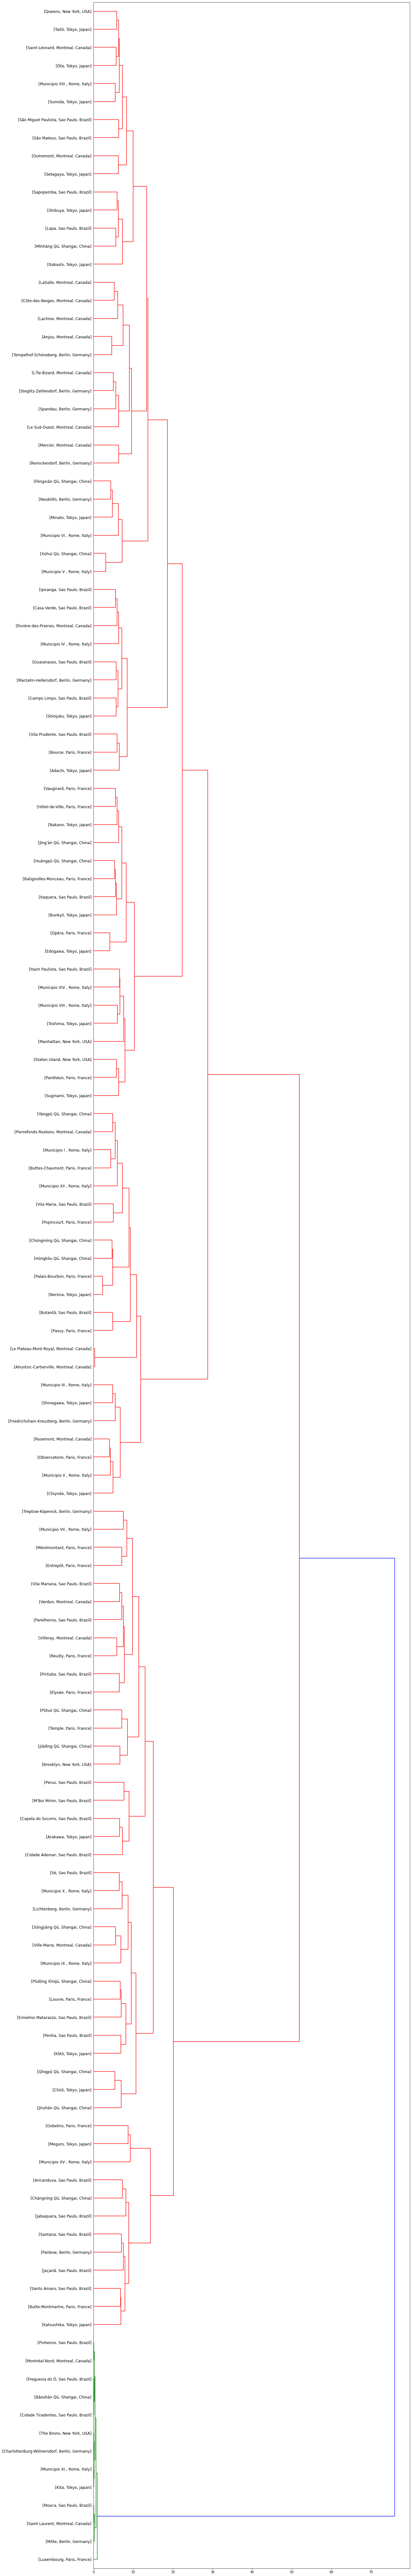

In [ ]:
features_2 = df_grouped_2.drop(df_grouped_2[["Borough","Population", "Area","city","country", "Longitude", "Latitude"]], axis=1)

#Let's normalize our features
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(features_2.values)

leng = X.shape[0]
D = scipy.zeros([leng,leng])
for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(X[i], X[j])

Z = linkage(D, 'ward')

#Function for the dendrogram's labels
def llf(id):
    return '[%s, %s, %s]' % (df_grouped['Borough'][id], df_grouped['city'][id], df_grouped['country'][id]) 

#Let's display our dendrogram
fig = pylab.figure(figsize=(18,150))
dendro = dendrogram(Z,  leaf_rotation=0, leaf_font_size =12, leaf_label_func=llf, orientation = 'right')
plt.show()

On the graph above, we see that Manhattan is quite similar to Toshima (Tokyo, Japan), Panthéon (Paris, France) and Staten Island (New York, USA). Let's see if we obtain similar results with a KMean.

### 4.B K-Means clustering

When using K-Means, it is generally strongly advised to check for the number of cluster to use beforehand. To achieve this, we will use two metrics: the elbow-method and the silhouette score.

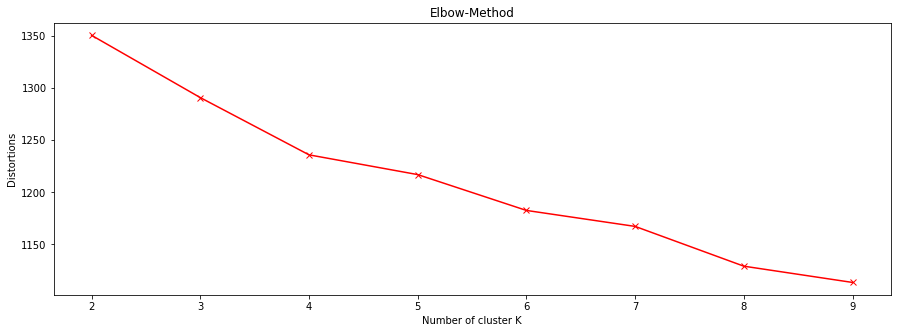

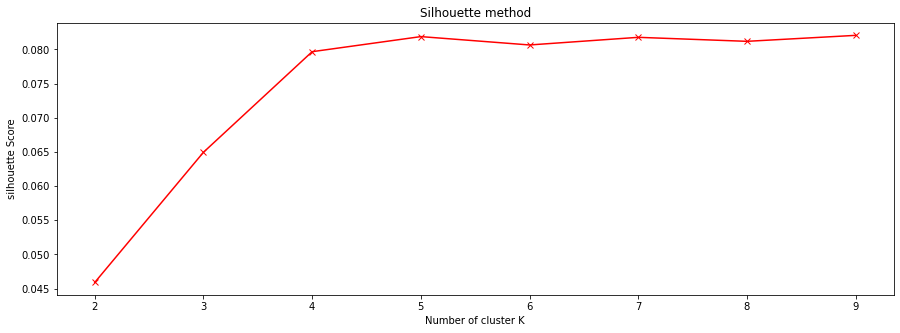

In [ ]:
# Maximum K value
Ks = range(2, 10)
distortions = []
# Best K using Elbow-Method
for k in Ks:
    kmeanModel = KMeans(n_clusters=k, init= 'k-means++', max_iter=500, random_state=1962).fit(X)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(15,5))
plt.plot(Ks, distortions, 'rx-')
plt.xlabel('Number of cluster K')
plt.ylabel('Distortions')
plt.title('Elbow-Method')
plt.show()

silhouette = []
for k in Ks:
    kmeanModels = KMeans(n_clusters=k, init='k-means++', max_iter=500, random_state=1962)
    X_predict = kmeanModels.fit_predict(X)
    centers = kmeanModels.cluster_centers_
    score = silhouette_score(X, X_predict, metric='euclidean')
    silhouette.append(score)

plt.figure(figsize=(15,5))
plt.plot(Ks, silhouette, 'rx-')
plt.xlabel('Number of cluster K')
plt.ylabel('silhouette Score')
plt.title('Silhouette method')
plt.show()

Judging by the graphs above, both 4 and 5 seem to be a good choice as the number of clusters for the K-mean. We will use a parsimonious approach and will stay with 4 here. As we have more than 3 dimensions, we have to rely on the TSNE (t-distributed stochastic neighbor embedding) method to reduce our dimensions to a number that can be plotted on a graph.

Before dimensions reductions: (142, 492)
After dimensions reductions: (142, 2)


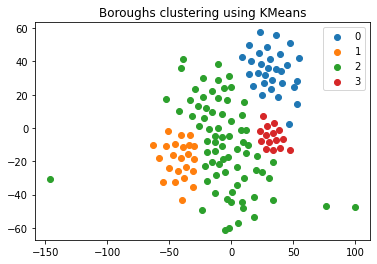

In [ ]:
K = 4  #Specify the nu
kmeanModel = KMeans(n_clusters=K, init= 'k-means++', max_iter=500, random_state=962).fit(X)
label = kmeanModel.predict(X)
df_grouped_2["Cluster"] = label

# We reduce the dimensions
print("Before dimensions reductions:", X.shape)
loc_emb = TSNE(random_state=962).fit_transform(X)
print("After dimensions reductions:", loc_emb.shape) #492 -> 2

# Plotting the clusters
for i in np.unique(label):
    plt.scatter(loc_emb[label == i , 0] , loc_emb[label == i , 1] , label = i)
plt.legend()
plt.title("Boroughs clustering using KMeans")
plt.show()

Let's retrieve the top venues for each of our boroughs.

In [ ]:
maximum_venues = 5
indicators = ['st', 'nd', 'rd']

#Let's create the column names
columns = ['Borough']
for ind in np.arange(maximum_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# Let's create a df that contains the top 5 venues per boroughs
df_top = pd.DataFrame(columns = columns)
df_dummy_2 = df_dummy.groupby("Borough").mean().reset_index()
df_top['Borough'] = df_dummy_2['Borough']
for index in np.arange(df_dummy_2.shape[0]):
    df_top.iloc[index, 1:] = return_top_venues(df_dummy_2.iloc[index, :], maximum_venues)

Now, let's define a function that takes as input a borough and returns a dataframe with all the similar boroughs in it (i.e., that belongs to the same cluster).

---



In [ ]:
#We define a function t
def find_similar_borough(Borough):
  clu = df_grouped_2.loc[df_grouped_2['Borough'] == Borough, 'Cluster'].values[0]
  df = df_grouped_2[df_grouped_2["Cluster"]==clu]
  df = df[["Borough", "Population", "Density", 	"Area", "Latitude", "Longitude", "country", "city", "Cluster"]]
  df = df.merge(df_top, on="Borough")
  ICD.display(df.head())

#Let's see whether the three boroughs that were similar in the Agglomerative clustering are in the same cluster as Manhattan
print("Boroughs similar to Manhattan")
find_similar_borough("Manhattan")
print("\nBoroughs similar to Panthéon, Paris")
find_similar_borough("Panthéon")
print("\nBoroughs similar to Staten Island")
find_similar_borough("Staten Island")	
print("\nBoroughs similar to Toshima, Tokyo")
find_similar_borough("Toshima")	

Boroughs similar to Manhattan


,Borough,Population,Density,Area,Latitude,Longitude,country,city,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Ahuntsic-Cartierville,134245,5547.3,24.2,45.541892,-73.680319,Canada,Montreal,2,Pharmacy,Café,Coffee Shop,Liquor Store,Bakery
1,Anjou,42796,3123.8,13.7,45.604898,-73.546672,Canada,Montreal,2,Pharmacy,Coffee Shop,Restaurant,Breakfast Spot,Liquor Store
2,Batignolles-Monceau,168737,29760,5.669,48.880754,2.303168,France,Paris,2,French Restaurant,Hotel,Italian Restaurant,Bakery,Restaurant
3,Bourse,100196,17924,5.59,48.868630,2.341474,France,Paris,2,Japanese Restaurant,French Restaurant,Coffee Shop,Italian Restaurant,Pastry Shop
4,Brooklyn,2559903,13957,183.42,40.650104,-73.949582,USA,New York,2,Caribbean Restaurant,Bakery,Grocery Store,Pizza Place,Coffee Shop



Boroughs similar to Panthéon, Paris


,Borough,Population,Density,Area,Latitude,Longitude,country,city,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Ahuntsic-Cartierville,134245,5547.3,24.2,45.541892,-73.680319,Canada,Montreal,2,Pharmacy,Café,Coffee Shop,Liquor Store,Bakery
1,Anjou,42796,3123.8,13.7,45.604898,-73.546672,Canada,Montreal,2,Pharmacy,Coffee Shop,Restaurant,Breakfast Spot,Liquor Store
2,Batignolles-Monceau,168737,29760,5.669,48.880754,2.303168,France,Paris,2,French Restaurant,Hotel,Italian Restaurant,Bakery,Restaurant
3,Bourse,100196,17924,5.59,48.868630,2.341474,France,Paris,2,Japanese Restaurant,French Restaurant,Coffee Shop,Italian Restaurant,Pastry Shop
4,Brooklyn,2559903,13957,183.42,40.650104,-73.949582,USA,New York,2,Caribbean Restaurant,Bakery,Grocery Store,Pizza Place,Coffee Shop



Boroughs similar to Staten Island


,Borough,Population,Density,Area,Latitude,Longitude,country,city,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Ahuntsic-Cartierville,134245,5547.3,24.2,45.541892,-73.680319,Canada,Montreal,2,Pharmacy,Café,Coffee Shop,Liquor Store,Bakery
1,Anjou,42796,3123.8,13.7,45.604898,-73.546672,Canada,Montreal,2,Pharmacy,Coffee Shop,Restaurant,Breakfast Spot,Liquor Store
2,Batignolles-Monceau,168737,29760,5.669,48.880754,2.303168,France,Paris,2,French Restaurant,Hotel,Italian Restaurant,Bakery,Restaurant
3,Bourse,100196,17924,5.59,48.868630,2.341474,France,Paris,2,Japanese Restaurant,French Restaurant,Coffee Shop,Italian Restaurant,Pastry Shop
4,Brooklyn,2559903,13957,183.42,40.650104,-73.949582,USA,New York,2,Caribbean Restaurant,Bakery,Grocery Store,Pizza Place,Coffee Shop



Boroughs similar to Toshima, Tokyo


,Borough,Population,Density,Area,Latitude,Longitude,country,city,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adachi,674067,12660,53.25,35.783703,139.795319,Japan,Tokyo,1,Convenience Store,Supermarket,Discount Store,Ramen Restaurant,Fast Food Restaurant
1,Arakawa,213648,21030,10.16,35.737529,139.781310,Japan,Tokyo,1,Convenience Store,Grocery Store,Ramen Restaurant,Japanese Restaurant,Japanese Family Restaurant
2,Bunkyō,223389,19790,11.29,35.718810,139.744732,Japan,Tokyo,1,Convenience Store,Ramen Restaurant,Grocery Store,Café,Italian Restaurant
3,Chiyoda,59441,5100,11.66,35.693810,139.753216,Japan,Tokyo,1,Café,Ramen Restaurant,Japanese Curry Restaurant,Chinese Restaurant,Historic Site
4,Chūō,147620,14460,10.21,35.666255,139.775565,Japan,Tokyo,1,Convenience Store,Park,Ramen Restaurant,Sushi Restaurant,Donburi Restaurant


As shown on the datasets above, only the Toshima borough was in a different cluster as Manhattan's.

# 5. Conclusion and open avenues

In this project, we aimed to see if we could group boroughs based on their similarity, namely their density of population and their most popular venues. We first extracted the data needed, cleaned and prepared it, and then cluster boroughs using both an agglomerative and a k-means clustering approach. With the k-mean model, the user can enter a borough and see a similar borough to the one he/she entered.

In this project, we focused on boroughs, but this process could be applied to neighborhoods as well. While this was the intent originally, the lack of census data regarding certain cities (e.g.: Rome, Sao Paulo) led us to only focus on boroughs. Furthermore, this work could be expanded, for instance, by using more variables, such as the socio-economic status of the boroughs or their criminality and education level. Those additional criteria would help to refine the model and perhaps get a more precise clustering.  

Thank you for reading!